# Bitcoin price movements prediction
Final project of the Deep Learning and Reinforcement Learning at Coursera

The objective of the analysis is to create a model for forecasting movements of the Bitcoin price. The main focus will be at the recurrent Network architecture, as they provide suitable framework for predicting time series. The target variable -- the price change is derived from the histtorical prices of Bitcoin.

YahooFinance is the source of historical prices. The time range of the price is from 2015 up to date. The dataset is a univariate distribution of the historical records of the Bitcoin price.

The benefits of the analysis is that it can serve as a proxy for risk-managers, traders and investors. ML models enables business stackeholders to make data-driven decisions.

# Exploration

In [1]:
import yfinance as yf
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import initializers

Using TensorFlow backend.


In [2]:
# Assumptions
ticker = "BTC-USD"
y_label = "Close"
x_labels = ["Open", "High", "Low", "Volume"]

## Collect data

In [3]:
def fetch_data(ticker):
    return yf.download(ticker, start="2015-01-01")

In [4]:
data = fetch_data(ticker)

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100


## Explore, plot, transform

Consider "Open", "High", "Low", "Volume" as features and "Close" as the target variable we want to predict.

In [6]:
dataX = data[x_labels]
dataX

,Open,High,Low,Volume
Date,,,,
2014-12-31,310.914001,320.192993,310.210999,13942900
2015-01-01,320.434998,320.434998,314.002991,8036550
2015-01-02,314.079010,315.838989,313.565002,7860650
2015-01-03,314.846008,315.149994,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,55629100
...,...,...,...,...
2021-04-03,59397.410156,60110.269531,57603.890625,59641344484
2021-04-04,57604.839844,58913.746094,57168.675781,50749662970
2021-04-05,58760.875000,59891.296875,57694.824219,60706272115


In [7]:
dataY = data[y_label].pct_change()
dataY

Date
2014-12-31         NaN
2015-01-01   -0.018564
2015-01-02    0.002492
2015-01-03   -0.107767
2015-01-04   -0.060079
                ...   
2021-04-03   -0.029981
2021-04-04    0.020045
2021-04-05    0.005094
2021-04-06   -0.014655
2021-04-07   -0.036063
Name: Close, Length: 2286, dtype: float64

In [8]:
dataY.dropna(inplace=True)
dataY

Date
2015-01-01   -0.018564
2015-01-02    0.002492
2015-01-03   -0.107767
2015-01-04   -0.060079
2015-01-05    0.038907
                ...   
2021-04-03   -0.029981
2021-04-04    0.020045
2021-04-05    0.005094
2021-04-06   -0.014655
2021-04-07   -0.036063
Name: Close, Length: 2285, dtype: float64

In [9]:
dataX.describe()

,Open,High,Low,Volume
count,2286.000000,2286.000000,2286.000000,2.286000e+03
mean,6863.935231,7058.736893,6666.092562,1.195920e+10
std,9699.273945,10023.669488,9370.013398,1.849213e+10
min,176.897003,211.731003,171.509995,7.860650e+06
25%,606.252991,608.607986,602.094238,7.866035e+07
50%,4608.364990,4804.889893,4443.415039,4.178700e+09
75%,9124.032227,9280.046631,8885.540771,1.812027e+10
max,61221.132812,61683.863281,59302.316406,3.509679e+11


In [10]:
# check the missing values
dataX.isnull().any()

Open      False
High      False
Low       False
Volume    False
dtype: bool

<AxesSubplot:xlabel='Date'>

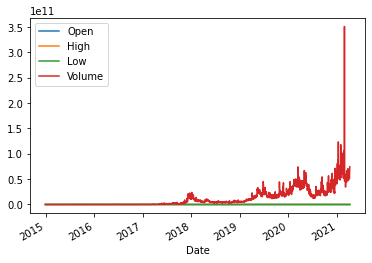

In [11]:
dataX.plot()

### Correlation of features

In [12]:
corrX = dataX.corr()
corrX

,Open,High,Low,Volume
Open,1.000000,0.999358,0.998957,0.775357
High,0.999358,1.000000,0.998846,0.777448
Low,0.998957,0.998846,1.000000,0.771212
Volume,0.775357,0.777448,0.771212,1.000000


<AxesSubplot:>

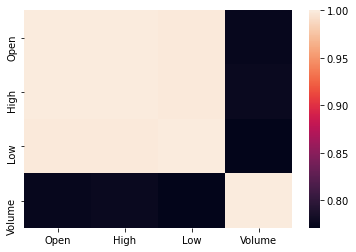

In [13]:
sns.heatmap(corrX)

Price exhibits a trend, volatility spikes, therefore it is not stationary. The objective is to predict price movements, not to forecast price itself. Therefore, compute (return) percentage difference of between observations. Create more features by increasing the rolling window.

In [14]:
dataX = dataX.pct_change()
dataX.dropna()

,Open,High,Low,Volume
Date,,,,
2015-01-01,0.030623,0.000756,0.012224,-0.423610
2015-01-02,-0.019835,-0.014343,-0.001395,-0.021888
2015-01-03,0.002442,-0.002181,-0.103593,3.205047
2015-01-04,-0.107036,-0.088593,-0.083499,0.682956
2015-01-05,-0.057130,-0.030947,0.029005,-0.209716
...,...,...,...,...
2021-04-03,0.005051,-0.002604,-0.021495,0.015555
2021-04-04,-0.030179,-0.019905,-0.007555,-0.149086
2021-04-05,0.020068,0.016593,0.009203,0.196191


In [15]:
def more_features(data, window=5):
    for label in data:
        for w in range(1,window+1):
            data[f"{label}_{w}"] = data[label].pct_change(periods=w)
    return data.dropna()

In [16]:
dataX = more_features(dataX, window=10)

In [17]:
dataX

,Open,High,Low,Volume,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,...,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,Volume_8,Volume_9,Volume_10
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-11,-0.044187,-0.029463,-0.032584,0.192377,-3.536092,0.105929,-2.568728,-2.058275,-2.229479,-0.226562,...,-2.042477,-4.041517,-1.979424,1.758582,-1.408234,-1.917322,-0.718317,-0.939977,-9.789353,-1.454137
2015-01-12,-0.030815,-0.026588,0.000607,0.037334,-0.302623,-2.768611,-0.228751,-2.093994,-1.738016,-1.857410,...,-0.805936,-1.202308,-1.590250,-1.190071,-0.464657,-1.079224,-1.178020,-0.945335,-0.988352,-2.705701
2015-01-13,0.004689,-0.014423,-0.170792,2.858196,-1.152174,-1.106123,-0.730864,-1.117364,-0.833523,-0.887693,...,75.558439,13.857268,-16.488358,-46.188629,-15.551562,39.984994,-7.065246,-14.628905,3.185037,-0.108220
2015-01-14,-0.162681,-0.165437,-0.220076,0.340383,-35.692643,4.279315,2.681671,-10.337056,3.071666,-6.775541,...,-0.880910,8.117345,0.769352,-2.844509,-6.381514,-2.732946,3.880903,-1.722310,-2.623066,-0.501604
2015-01-15,-0.209907,0.023105,0.031409,-0.162489,0.290298,-45.763835,5.811888,3.750451,-13.047582,4.253661,...,-1.477371,-1.056850,-5.352358,-1.844638,-0.119485,1.568980,-0.172742,-3.330002,-0.655190,-0.225195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-03,0.005051,-0.002604,-0.021495,0.015555,0.727408,-81.132463,-0.752811,-0.843187,-11.455621,-0.667388,...,-1.326126,-1.264599,-0.923795,-1.279105,-0.925371,0.750335,-1.093888,-1.093209,-1.427528,-0.937885
2021-04-04,-0.030179,-0.019905,-0.007555,-0.149086,-6.974453,-11.320320,477.747615,-2.476816,-1.936874,61.466615,...,-10.584728,2.125826,1.536107,-1.730403,1.675148,-1.715302,-17.776487,-0.100112,-0.106613,3.097737
2021-04-05,0.020068,0.016593,0.009203,0.196191,-1.664972,2.972844,5.862724,-319.353773,-0.017958,-0.377005,...,-2.315957,11.613093,-5.113453,-4.337409,-0.038821,-4.520381,-0.058692,21.077141,-2.184215,-2.175659


In [18]:
dataX.describe()

,Open,High,Low,Volume,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,...,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,Volume_8,Volume_9,Volume_10
count,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,...,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000,2275.000000
mean,0.003081,0.002955,0.003083,0.050714,327.960374,333.679324,-66.325200,-170.031555,246.167412,-101.440464,...,-2.900966,0.357750,-0.232104,-0.481730,-1.910023,-1.375501,-2.398325,-0.748974,-1.121239,-8.844987
std,0.038833,0.035339,0.038113,0.361244,15384.867114,16107.799613,3105.007601,8031.009595,11467.426336,5030.393887,...,90.769217,49.914365,32.803934,43.576980,42.220920,78.811507,55.572965,68.905118,27.809291,437.192885
min,-0.365924,-0.263712,-0.364062,-0.869188,-821.814912,-7617.930475,-148085.909732,-383041.860326,-1014.986145,-239729.224009,...,-3663.453345,-712.708861,-834.585905,-864.416586,-1377.647748,-2935.579113,-1735.339829,-2449.388228,-585.517764,-20629.821762
25%,-0.011395,-0.009831,-0.008186,-0.136942,-1.922773,-1.972778,-2.001886,-1.975130,-1.941623,-1.922819,...,-2.145341,-2.084134,-2.052501,-2.009198,-2.073442,-1.981027,-1.769245,-1.979257,-2.012756,-2.050469
50%,0.002216,-0.000222,0.003488,-0.008393,-1.047061,-0.996241,-0.978789,-0.985535,-0.998252,-0.957052,...,-1.147255,-1.158715,-1.061447,-1.001607,-1.074672,-0.981271,-0.848433,-0.972588,-1.053246,-1.081444
75%,0.017896,0.014045,0.016596,0.163152,-0.019576,0.045182,-0.057118,0.058939,-0.024713,0.099760,...,-0.197999,-0.136269,-0.046975,-0.004640,-0.038136,0.034093,0.201824,0.000867,-0.081055,-0.112529
max,0.250461,0.245708,0.247892,5.439003,733653.952888,768244.076884,940.459272,557.649825,546865.781372,9336.683477,...,665.900071,1599.769761,738.960899,978.974107,903.304647,1913.058120,714.699320,1514.886885,546.157522,2520.323347


### Train-test split

In [19]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(dataX.values.astype('float32'), dataY[:dataX.shape[0]].astype('float32').values, test_size=0.3, random_state=42)

In [22]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1592, 44)
X_test shape: (683, 44)
y_train shape: (1592,)
y_test shape: (683,)


RNNs, LSTM take 3d input vector. Need to reshape data before training.

In [23]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [24]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1592, 1, 44)
X_test shape: (683, 1, 44)


In [25]:
X_train[123,:]

array([[  0.0289947 ,   0.05322506,   0.03165452,   0.37205392,
         -0.50368243,  -5.699338  ,   0.59175766,  -2.9662046 ,
         -7.8653016 ,  -0.26604334,   0.7238959 ,   6.1772995 ,
         -3.4237413 ,  -2.5930753 ,   3.0050037 ,  -0.34871322,
        -23.843575  ,   7.860183  ,  -3.428189  ,   4.010519  ,
          0.06644591,   2.123955  ,  -4.057812  ,  -4.985839  ,
         -0.42227048,   3.926843  ,   2.0996199 , -19.795649  ,
         -4.060236  ,  -0.07977978,   0.7877346 ,  10.546289  ,
        -14.165335  ,  -5.8832207 ,  -1.6300681 ,  -0.75046563,
          3.1429174 ,   0.32181612,  -1.9010227 ,   2.2865446 ,
         -0.7963382 ,  -3.074647  ,  -4.1843333 ,  -2.8358393 ]],
      dtype=float32)

In [26]:
y_train

array([ 0.02575586, -0.01477988, -0.00157765, ..., -0.09786476,
        0.00679408,  0.01809886], dtype=float32)

In [27]:
y_train.shape

(1592,)

## Modelling
Three different architectures of RNN are considered for predicting price movements. The first one serves as a baseline, and is nothing but an AR(p) model. Others two are LSTM and GRU.

# RNN

In [28]:
model = keras.Sequential()
model.add(layers.SimpleRNN(32, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(layers.LSTM(8))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                2464      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [29]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [30]:
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

Train on 1592 samples, validate on 683 samples
Epoch 1/10
1592/1592 [==============================] - 3s 2ms/sample - loss: 0.8431 - val_loss: 0.4175
Epoch 2/10
1592/1592 [==============================] - 1s 401us/sample - loss: 0.2248 - val_loss: 0.1998
Epoch 3/10
1592/1592 [==============================] - 1s 377us/sample - loss: 0.1092 - val_loss: 0.1359
Epoch 4/10
1592/1592 [==============================] - 1s 390us/sample - loss: 0.0697 - val_loss: 0.1088
Epoch 5/10
1592/1592 [==============================] - 1s 387us/sample - loss: 0.0490 - val_loss: 0.0883
Epoch 6/10
1592/1592 [==============================] - 1s 375us/sample - loss: 0.0363 - val_loss: 0.0718
Epoch 7/10
1592/1592 [==============================] - 1s 400us/sample - loss: 0.0273 - val_loss: 0.0598
Epoch 8/10
1592/1592 [==============================] - 1s 391us/sample - loss: 0.0209 - val_loss: 0.0491
Epoch 9/10
1592/1592 [==============================] - 1s 378us/sample - loss: 0.0163 - val_loss: 0.0402
E

In [32]:
import matplotlib.pyplot as plt

def plot_results(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

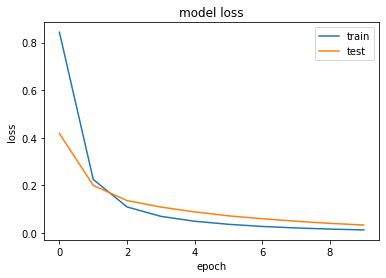

In [33]:
plot_results(history)

# LSTM

In [34]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                9856      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 9,889
Trainable params: 9,889
Non-trainable params: 0
_________________________________________________________________


In [35]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [36]:
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

Train on 1592 samples, validate on 683 samples
Epoch 1/10
1592/1592 [==============================] - 5s 3ms/sample - loss: 0.1214 - val_loss: 0.0743
Epoch 2/10
1592/1592 [==============================] - 1s 516us/sample - loss: 0.0372 - val_loss: 0.0480
Epoch 3/10
1592/1592 [==============================] - 1s 593us/sample - loss: 0.0185 - val_loss: 0.0369
Epoch 4/10
1592/1592 [==============================] - 1s 584us/sample - loss: 0.0113 - val_loss: 0.0302
Epoch 5/10
1592/1592 [==============================] - 1s 532us/sample - loss: 0.0071 - val_loss: 0.0261
Epoch 6/10
1592/1592 [==============================] - 1s 533us/sample - loss: 0.0053 - val_loss: 0.0225
Epoch 7/10
1592/1592 [==============================] - 1s 541us/sample - loss: 0.0040 - val_loss: 0.0206
Epoch 8/10
1592/1592 [==============================] - 1s 542us/sample - loss: 0.0032 - val_loss: 0.0185
Epoch 9/10
1592/1592 [==============================] - 1s 544us/sample - loss: 0.0028 - val_loss: 0.0171
E

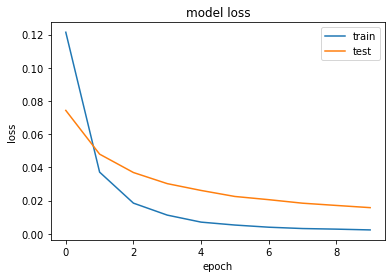

In [37]:
plot_results(history)

# GRU

In [38]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                9856      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 9,889
Trainable params: 9,889
Non-trainable params: 0
_________________________________________________________________


In [39]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

In [ ]:
plot_results(history)

## Findings and Implications

Financial time series are noisy and difficult to forecast. Moreover, the model assumes that the expected value depends solely on the prior (historical) observations, which is not the case. Adding alternative datasets and more features may improve predictive power of the model, but requires different modelling techniques aside from univariate time-series forecasting. Creating an MLP based an macroeconomic factors, market sentiments analysis as well as proxy market indices may improve model performance and make inference interpretable.